# Notebook Setup and Resources

This notebook is to serve as an overview of *Conformal Uncertainty Quantification* to be used in the final project for MATH 6388: Statistical and Machine Learning at the University of Colorado Denver, Fall 2023.

It will, to begin, contain an summary of the relevant theory/mathematics and examples illustrating the concepts.

This notebook draws heavily from the following resources:

A Tutorial on Conformal Prediction: https://www.youtube.com/watch?v=nql000Lu_iE&list=PLBa0oe-LYIHa68NOJbMxDTMMjT8Is4WkI&index=6

A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification: https://arxiv.org/abs/2107.07511

Conformal prediction under ambiguous ground truth: https://arxiv.org/abs/2307.09302

# Classification

## Problem Statement

In classification, our goal is to develop a model, call it $\hat{f}_y(x)$, which estimates the quantity $\pi_y(x) = \mathbb{P}[Y=y|X=x]$

This could be either a single value in $[0,1]$ for binary classification, or a probability vector over $K$ classes, such that $\pi_y(x) = [p_0,...,p_{K-1}], \sum_{i=0}^{K-1} p_i = 1$

Instead, we would like to have a better idea of what our model thinks about the new data point than a raw probability. We will construct a set $\hat{C}(x_{n+1}) \subseteq \mathcal{Y}$, where $\mathcal{Y}$ is all our possible classes (i.e., $|\mathcal{Y}| = K$), such that $\mathbb{P}[y_{n+1} \in \hat{C}(x_{n+1})] \geq 1-\alpha$.

In words, we are looking for a set of possible classes such that, with some probability $1- \alpha$, the *true* $y$ is in that set. Now, there is an obvious trivial solution, just let $\hat{C}(x_{n+1}) = \mathcal{Y}$, as the true label will be in the set of all labels with 100% probability, but this isn't interesting.

Thus, we will modify our objective to:

$$ \hat{C}(x_{n+1}) \subset \mathcal{Y} $$

Such that:

$$ \mathbb{P}[y_{n+1} \in \hat{C}(x_{n+1})] \geq 1-\alpha $$

We call $\geq 1-\alpha$ the *coverage* and $\alpha$ is the error rate, which has low values, such as 0.1, 0.05, etc.

Of course, this can't be our *only* criteria, because we could get a probability of $1-\alpha$ easily with:

$$ \hat{C} = \begin{cases} 
\mathcal{Y} & \text{with prob} & 1-\alpha \\
\emptyset & \text{with prob} & \alpha 
\end{cases}$$

So, we also want our set $\hat{C}(x_{n+1})$ to be *small* in some sense of the word and *adaptive* so that we get different sets for different inputs $x_{n+1}$.

## Method, the Least Ambiguous set-valued Classifier (LAC)

To begin, we will divide our data $\mathcal{X}$ into three sets, $\mathcal{X}_{train}$, $\mathcal{X}_{calibration}$, and $\mathcal{X}_{test}$. 

The $\mathcal{X}_{train}$ is our standard training set used to train the model $\hat{f}$.

Now, we have to introduce a *score* function, $s(x,y)$ which tells us how well, in some sense, our model is doing. For classification, the obvious choice is the probability of that specific class. As in, if $\hat{f}(x)_y = [p_0, \dots, p_{K-1}]$, we can take:

$$ s(x,y) = 1 - \hat{f}(x)_{y_i} = p_i, \text{i is the true class} $$

Now, why do we want $1 - \hat{f}(x)_{y_i}$? This will become apparent momentarily. It doesn't *really* matter, it just depends how we set everything up. One could take $\hat{f}_(x)_{y_i}$ as the score, but then everything we do below will be opposite. For now, we will stick to a *left* or *negative* formulation, which follows. 

For each element of our calibration set $\mathcal{X}_{cal}$ we repeat the above process, giving us $\{s_1, \dots, s_{n_{cal}} \}$.

From here, we are going to *order* them and find:

$$ \hat{q} = \lceil (1-\alpha)(n_{cal} +1) \rceil \quad \text{smallest of } s_i, i \in \{1, \dots, n_{cal} \}$$

Let's take a moment to write out what exactly this $\hat{q}$ is. It is the value such that at least $1-\alpha$ percent of examples in our calibration set have scores above this value.

We note that the above formulation is just the *quantile*:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

From this, we can construct our $\hat{C}(x_{test})$ as:

$$ \hat{C}(x_{test}) = \{y : s(x_{test}, y_{test}) \leq \hat{q}\} $$

Recalling our definition of $s(x,y)$, we can rewrite this as:

$$ \hat{C}(x_{test}) = \{y : \hat{f}(x_{test})_y \geq 1- \hat{q} \} $$

As in, since we don't have $y_{true}$ for our test point, we are choosing all the scores greater than $1 - \hat{q}$.

For a concrete example, consider that we have three classes and our softmaxed output is $\hat{f}(x_{test})_y = [0.4, 0.4, 0.2]$. If $\hat{q} = 0.7$, then $1-\hat{q} = 0.3$. So, we would get $\hat{C}(x_{test}) = \{0, 1\}$. In this case, we could say that with probability $1-\alpha$, the true class $y_{test}$ is either class $0$ or $1$.

Now, we mentioned that we could also use the *right* or *positive* version of this. We would then construct our set as:

$$ \hat{q} = \lfloor \alpha(n_{cal}+1) \rfloor \quad \text{smallest of } s_i, i \in \{1, \dots, n_{cal} \} $$

$$ \hat{C}(x_{test}) = \{y: s(x_{test}, y_{test}) \geq \hat{q} \} $$

$$ \hat{C}(x_{test}) = \{y : \hat{f}(x_{test})_y \leq 1 - \hat{q} \} $$

## Theorem 1

$$ 1 - \alpha \leq \mathbb{P}[(y_{test}) \in \hat{C}(x_{test})] \leq 1-\alpha + \frac{1}{n_{cal} + 1} $$ 

For *any* algorithm, dataset, $\alpha$, and $n_{cal}$.

## Alterative, the Top-K Algorithm

In the *Top-K* algorithm, we will modify our score function a bit.

It will be:

$$ s(x,y) = j \quad \text{where} \quad y_i = j \quad \text{and} \quad \hat{f}(x)_{\pi_1(x)} > \dots \hat{f}(x)_{\pi_j(x)} \dots > \hat{f}(x)_{\pi_K(x)} $$

Where $\pi(x)$ is the permutation of $\{ 1, \dots, K \}$ that sorts $\hat{f}(x)$ from most likely to least. For a concrete example, suppose we have four classes and our output is $\hat{f}_y(x)=[0.4, 0.2, 0.3, 0.1]$. We would rearrange our scores to get $[0.4, 0.3, 0.2, 0.1]$, which amounts to $\pi(x) = \{ 1, 3, 2, 4 \}$. If the true class is $y=3$, then we would have $s(x,y) = 2$, because in the permutation, class $3$ is in location $2$.

Then, as above, we calculate:

$$ \hat{q} = \left\lceil quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) \right\rceil$$

And our final prediction set is:

$$\hat{C}(x_{test}) = \{ \pi_1(x_{test}), \dots, \pi_{\hat{q}}(x_{test}) \} $$

## Alternative 2, the Adapative Prediction Sets (APS) Algorithm

There are a few issues with the LAC method above. One is that it only uses the output of the model on the calibration set for the true class for each score. This means it is throwing away a large portion of the possible data we might have. Second, it is not as adaptive. However, it does produce on average a smaller size for our $\hat{C}$, which is nice.

Now, we will look at improving the method. The first change will be our scoring function. Before, our score was:

$$ s(x,y) = 1 - \hat{f}_{y_i}(x) = p_i, \text{i is the true class} $$

Now, we will take all the softmaxed output scores and arrange them by size, then take the sum up to the correct class. As in:

$$ s(x,y) = \sum_{j=1}^{k} \hat{f}(x)_{\pi_j{(x)}}, \quad y = \pi_k(x)$$

Consider the example above, where we have four classes and $y_{true} = 3$ (starting our index at 1), or the third class. If our softmax output is $\hat{f}_y(x)=[0.4, 0.2, 0.3, 0.1]$, we would rearrange our scores to get $[0.4, 0.3, 0.2, 0.1]$ and then sum them up to the rank of $y_{true}$ in this permutation, which would be 2. Thus, $s(x,y)= 0.4 + 0.3 =0.7$ in this case.

Now, we proceed as normal:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

$$ \hat{C}(x_{\text{test}}) = \{ \pi_1(x_{test}), \dots, \pi_k(x_{test}) \}, \quad k = \sup \left\{ k' : \sum_{j=1}^{k'} \hat{f}(x)_{\pi_j(x)} < \hat{q} \right\} (+ 1 \quad \text{If we want to avoid zero-size sets}) $$

For an example, let's say that $\hat{f}(x_{test}) = [0.3, 0.14, 0.16, 0.4]$ and $\hat{q} = 0.8$. Then, we would order $\hat{f}(x_{test})$ to get $[0.4, 0.3, 0.16, 0.14]$. This means our permutation is $\{4, 1, 3, 2\}$. We would then see that $0.4 + 0.3$ add to $0.7$, and adding $0.15$ puts us over, so we stop after that (as in, we add until we go over, but *we can go over*). This means $k=3$. Now, $0.4$, $0.3$, and $0.16$ correspond to classes $4$, $1$, and $3$ respectively, so we get $\hat{C}(x_{test}) = \{ \pi_1(x_{test}), \pi_2(x_{test}), \pi_3(x_{test}) \} = \{1, 3, 4\}$.

## Improvements to the APS, Regularized Adaptive Prediction Sets (RAPS)

We begin with the same score function, but modify it slightly to:

$$ s(x,y) = \sum_{j=1}^{k} \hat{f}(x)_{\pi_j{(x)}} + \lambda(k-k_{reg})^+, \quad y = \pi_k(x)$$

Where $\pi(x)$ is the permutation of $\{ 1, \dots, K \}$ that sorts $\hat{f}(x)$ from most likely to least, $(z)^+$ denotes the positive part of $z$, $k_{reg}$ is the optimal set size (in the sense that if all prediction sets have $k_{reg}$ elements, then one achieves the desired coverage), and $\lambda$ is a regularization parameter whose calculation we will explain next.

The optimizations of $k_{reg}$ and $\lambda$ requires an extra data-splitting (by default, 20% of the calibration data). To choose $k_{reg}$, we simply run the Top-K method over this new split and set $k_{reg} = \hat{q}$. For the choice of $\lambda$, we follow the guidelines of [3] and try to find the value of lambda such that it minimizes the size of the prediction sets.

Now, we proceed as normal:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

$$ \hat{C}(x_{\text{test}}) = \{ \pi_1(x_{test}), \dots, \pi_k(x_{test}) \}, \quad k = \sup \left\{ k' : \sum_{j=1}^{k'} \hat{f}(x)_{\pi_j(x)} + \lambda(k-k_{reg})^+ < \hat{q} \right\} (+ 1 \quad \text{If we want to avoid zero-size sets}) $$

[3]: Anastasios Nikolas Angelopoulos, Stephen Bates, Michael Jordan and Jitendra Malik. “Uncertainty Sets for Image Classifiers using Conformal Prediction.” International Conference on Learning Representations 2021.

## General Pipeline

1. Identify a *heuristic* notion of uncertainity. Could be softmax, residuals, etc. 
2. Define a score function. Perhaps $1-\hat{f}(x)$ for classification, or $|\hat{f}(x) - y|$ for regression, etc.
3. Compute $\hat{q}$ with calibration data.
4. Create $\hat{C}(x) = \{ y: s(x,y) \leq \hat{q} \}$.

# Worked Examples

In [1]:
# PyTorch Classification Model and Associated Functions

## Imports
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

## Dataloaders
def create_dataset_dataloader(X, y, batch_size, shuffle):
    
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

## Define the PyTorch model
class CLF_MLP(nn.Module):
    def __init__(self, input_size, num_neurons):
        super(CLF_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.activation = nn.LeakyReLU(negative_slope=0.3)
        self.fc2 = nn.Linear(num_neurons, 3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

## Create the Model
def create_and_initialize_classification_model(X_train, num_neurons):
    ## Initialize the model
    input_size = X_train.shape[1]
    model = CLF_MLP(input_size, num_neurons)

    ## Define loss function and optimizer
    criterion = nn.CrossEntropyLoss() # No need for a final softmax layer in the model, as this will apply softmax. No need for one-hot encoding, either!
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    return model, criterion, optimizer

## Accuracy Function
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

## Model Training Function
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    model.train()
    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            running_accuracy += accuracy

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)

        # Store loss and accuracy for plotting
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

    # Plotting the performance
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Prediction
def model_prediction_classification(model, inputs):
    # Set the model to evaluation mode
    model.eval()

    # Use the model to predict probabilities for the calibration set
    with torch.no_grad():
        outputs_cal = model(inputs)
        y_prob = torch.nn.functional.softmax(outputs_cal, dim=1).numpy()

    return y_prob

In [17]:
# Conformal Uncertainity Quantification Functions

# Get calibration scores 
def get_calibration_scores_orig(X_cal, y_cal, y_cal_prob):

    n_cal = X_cal.shape[0]

    cal_scores = 1 - y_cal_prob[np.arange(n_cal), y_cal]

    return cal_scores

def get_calibration_scores_adaptive(X_cal, y_cal, y_cal_prob):

    # Setup
    n_cal=X_cal.shape[0] # number of calibration points

    # Calibration Scores
    cal_pi = y_cal_prob.argsort(1)[:, ::-1]
    cal_srt = np.take_along_axis(y_cal_prob, cal_pi, axis=1).cumsum(axis=1)
    cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
        range(n_cal), y_cal
    ]

    print('cal_pi', cal_pi.shape)
    print('cal_srt',cal_srt.shape)
    print('cal_scores', cal_scores.shape)

    return cal_scores

# Get adjusted quantile

def find_quantile(cal_scores, alpha):

    n_cal = cal_scores.shape[0]

    q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal

    qhat = np.quantile(cal_scores, q_level, method='higher')
    
    return qhat 

# Plot calibration scores and adjusted quantile for various alpha 

def plot_scores(alphas, cal_scores, quantiles, y_max):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(5, 3))
    plt.rcParams.update({'font.size': 12})
    plt.hist(cal_scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=y_max,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()


def cuq_pred_set_orig(cal_scores, alpha, model, X_test, y_test):

    qhat = find_quantile(cal_scores, alpha)
    y_test_probs = model_prediction_classification(model, X_test)
    prediction_sets = y_test_probs >= (1-qhat) 

    # Mean width of prediction set
    mean_width = prediction_sets.sum(axis=1).mean()

    ## Percent coverage if we have y_test
    if y_test != None:
        pct_coverage = prediction_sets[np.arange(X_test.shape[0]), y_test].mean()

    print(f'Example prediction sets: {prediction_sets[:5]}')
    print('\n')
    print(f'Mean Width of Prediction Set: {mean_width}')

    if y_test != None:
        print('\n')
        print(f'Percent Coverage: {pct_coverage}')

        return prediction_sets, mean_width, pct_coverage, qhat

    else:
        return prediction_sets, mean_width, qhat

def cuq_pred_set_lar(model, cal_scores, X_test_tensor, y_test, alpha):
    # Get the score quantile
    qhat = find_quantile(cal_scores, alpha)
    # Deploy
    test_probs = model_prediction_classification(model, X_test_tensor)
    val_pi = test_probs.argsort(1)[:, ::-1]
    val_srt = np.take_along_axis(test_probs, val_pi, axis=1).cumsum(axis=1)
    prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

    print('cal_scores', cal_scores.shape)
    print('qhat', qhat.shape)
    print('test_probs', test_probs.shape)
    print('val_pi',val_pi.shape)
    print('prediction_sets',prediction_sets.shape)

    # Mean width of prediction set
    mean_width = prediction_sets.sum(axis=1).mean()

    ## Percent coverage if we have y_test
    try:
        pct_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), y_test].mean()

    except:
        print(f'Example prediction sets: {prediction_sets[:5]}')
        print('\n')
        print(f'Mean Width of Prediction Set: {mean_width}')

    try:
        print('\n')
        print(f'Percent Coverage: {pct_coverage}')
        return prediction_sets, mean_width, pct_coverage, qhat
    except:
        return prediction_sets, mean_width, qhat

## Classification

### Synthetic Classification

#### Data Generation

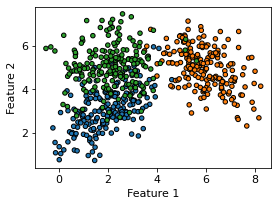

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(5)

# Generate synthetic data for three-class classification
mean_class_1 = [2, 3]
cov_class_1 = [[1, 0.5], [0.5, 1]]
data_class_1 = np.random.multivariate_normal(mean_class_1, cov_class_1, 200)

mean_class_2 = [6, 5]
cov_class_2 = [[1, -0.5], [-0.5, 1]]
data_class_2 = np.random.multivariate_normal(mean_class_2, cov_class_2, 200)

mean_class_3 = [2, 5]
cov_class_3 = [[1, 0], [0, 1]]
data_class_3 = np.random.multivariate_normal(mean_class_3, cov_class_3, 200)

# Combine the three classes into a single dataset
X = np.vstack((data_class_1, data_class_2, data_class_3))
y = np.hstack((np.zeros(200, dtype=int), np.ones(200, dtype=int),
               2 * np.ones(200, dtype=int)))  

# Plot the synthetic data
plt.rcParams.update({'font.size': 11, "figure.figsize": (4,3)})
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_col = list(map(colors.get, y))

plt.scatter(X[:, 0], X[:, 1], c=y_col, marker='o', s=20, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

#### Data preparation

In [19]:
# Data Preparation

from sklearn.model_selection import train_test_split

X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=1/2, random_state=42)

print(f' X_train shape: {X_train.shape}, X_cal shape: {X_cal.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}')

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_cal_tensor = torch.Tensor(X_cal)
y_cal_tensor = torch.LongTensor(y_cal)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

 X_train shape: (200, 2), X_cal shape: (200, 2), X_test shape: (200, 2), y_train shape: (200,)


#### Training

Epoch 1, Loss: 0.9085504841804505, Accuracy: 0.595
Epoch 2, Loss: 0.7823816299438476, Accuracy: 0.63
Epoch 3, Loss: 0.7288480257987976, Accuracy: 0.64
Epoch 4, Loss: 0.6988606810569763, Accuracy: 0.645
Epoch 5, Loss: 0.6798127603530884, Accuracy: 0.655
Epoch 6, Loss: 0.6598459804058074, Accuracy: 0.66
Epoch 7, Loss: 0.6593426585197448, Accuracy: 0.65
Epoch 8, Loss: 0.6418490087985993, Accuracy: 0.645
Epoch 9, Loss: 0.6375942528247833, Accuracy: 0.685
Epoch 10, Loss: 0.6324562752246856, Accuracy: 0.68
Epoch 11, Loss: 0.6203732967376709, Accuracy: 0.67
Epoch 12, Loss: 0.6078579384088516, Accuracy: 0.7
Epoch 13, Loss: 0.6023259222507477, Accuracy: 0.705
Epoch 14, Loss: 0.5988533771038056, Accuracy: 0.7
Epoch 15, Loss: 0.5929466283321381, Accuracy: 0.72
Epoch 16, Loss: 0.5864815849065781, Accuracy: 0.735
Epoch 17, Loss: 0.5768194174766541, Accuracy: 0.74
Epoch 18, Loss: 0.5745164144039154, Accuracy: 0.765
Epoch 19, Loss: 0.5762987762689591, Accuracy: 0.75
Epoch 20, Loss: 0.5658773744106292

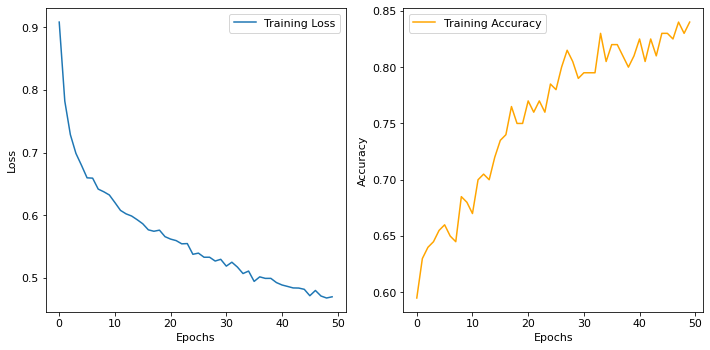

In [20]:
# Training

## Creating the model
num_neurons = 32
model, criterion, optimizer = create_and_initialize_classification_model(X_train_tensor, num_neurons)

## Getting the data loaders
batch_size = 8
train_loader = create_dataset_dataloader(X_train_tensor, y_train_tensor, batch_size, True)
cal_loader = create_dataset_dataloader(X_cal_tensor, y_cal_tensor, batch_size, True)
test_loader = create_dataset_dataloader(X_test_tensor, y_test_tensor, batch_size, True)

## Model Training
num_epochs = 50
train_model(model, criterion, optimizer, train_loader, num_epochs)

#### Conformal Uncertainity Quantification

##### Original

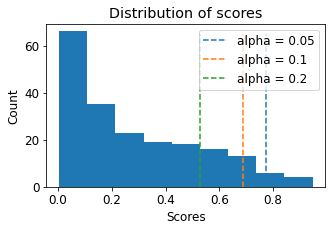

In [21]:
# Conformal Uncertainity Quantification

## Cal model output probabilities
y_cal_prob = model_prediction_classification(model, X_cal_tensor)
cal_scores = get_calibration_scores_orig(X_cal_tensor, y_cal_tensor, y_cal_prob)

## Quantiles
alphas = [0.05, 0.1, 0.2]
quantiles = [find_quantile(cal_scores, alpha) for alpha in alphas]

## Plotting
plot_scores(alphas, cal_scores, quantiles, 65)

In [22]:
# Prediction Set

prediction_sets, mean_width, pct_coverage, qhat = cuq_pred_set_orig(cal_scores, 0.05, model, X_test_tensor, y_test_tensor)
print(f'Example prediction set: {prediction_sets[0]}')
print(f'Mean width: {mean_width}')
print(f'Percent/Emprical Coverage {pct_coverage}')
print(f'Associated q_hat: {qhat}')

Example prediction sets: [[ True  True False]
 [ True False  True]
 [ True False  True]
 [ True False  True]
 [ True False  True]]


Mean Width of Prediction Set: 1.44


Percent Coverage: 0.97
Example prediction set: [ True  True False]
Mean width: 1.44
Percent/Emprical Coverage 0.97
Associated q_hat: 0.7726549506187439


##### Adaptive

cal_pi (200, 3)
cal_srt (200, 3)
cal_scores (200,)


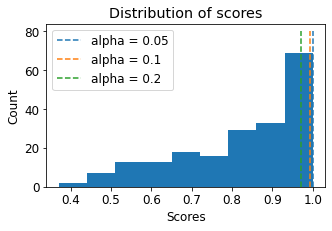

In [23]:
# Conformal Uncertainity Quantification

## Cal model output probabilities
y_cal_prob = model_prediction_classification(model, X_cal_tensor)
cal_scores = get_calibration_scores_adaptive(X_cal, y_cal, y_cal_prob)

## Quantiles
alphas = [0.05, 0.1, 0.2]
quantiles = [find_quantile(cal_scores, alpha) for alpha in alphas]

## Plotting
plot_scores(alphas, cal_scores, quantiles, 80)

In [24]:
# Prediction Set

prediction_sets, mean_width, pct_coverage, qhat = cuq_pred_set_lar(model, cal_scores, X_test_tensor, y_test, 0.1)
print(f'Example prediction set: {prediction_sets[0]}')
print(f'Mean width: {mean_width}')
print(f'Percent/Emprical Coverage {pct_coverage}')
print(f'Associated q_hat: {qhat}')

cal_scores (200,)
qhat ()
test_probs (200, 3)
val_pi (200, 3)
prediction_sets (200, 3)


Percent Coverage: 0.93
Example prediction set: [ True  True False]
Mean width: 1.6
Percent/Emprical Coverage 0.93
Associated q_hat: 0.9924300312995911


Note, with the adaptive, you're guaranteed to have at least one class.

### Real Classification

#### Data Loading

In [10]:
# Loading in the data

from sklearn.datasets import load_wine

data = load_wine(as_frame = True)

df_raw = data['data']

df_raw['class'] = data['target'] 

print(f'Our dataset has {len(df_raw)} rows and {len(df_raw.columns)} columns.')
print(f"There are {len(np.unique(df_raw['class']))} classes.")
print(f'They are {df_raw.columns}')
df_raw.head()

Our dataset has 178 rows and 14 columns.
There are 3 classes.
They are Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'class'],
      dtype='object')


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


#### Data preparation

In [11]:
# Data Preparation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Creating X and y
X = np.array(df_raw.drop(columns = ['class'])) # We are using all the features, so we will drop the 'class' column from the dataset
y = np.array(df_raw['class'])

## Splitting
X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=1/2, random_state=42)

print(f' X_train shape: {X_train.shape}, X_cal shape: {X_cal.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}')

## Fitting the standard scaler on X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Fitting and transforming on X_train
X_test = scaler.transform(X_test) # Only transforming on the X_test
X_cal = scaler.transform(X_cal) # Only transforming on the X_test


## Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_cal_tensor = torch.Tensor(X_cal)
y_cal_tensor = torch.LongTensor(y_cal)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

 X_train shape: (59, 13), X_cal shape: (59, 13), X_test shape: (60, 13), y_train shape: (59,)


#### Training

Epoch 1, Loss: 1.0331644713878632, Accuracy: 0.4791666666666667
Epoch 2, Loss: 0.9573723450303078, Accuracy: 0.5989583333333334
Epoch 3, Loss: 0.8895149007439613, Accuracy: 0.703125
Epoch 4, Loss: 0.8332795798778534, Accuracy: 0.765625
Epoch 5, Loss: 0.7918970808386803, Accuracy: 0.8177083333333334
Epoch 6, Loss: 0.7392884567379951, Accuracy: 0.890625
Epoch 7, Loss: 0.6791606247425079, Accuracy: 0.90625
Epoch 8, Loss: 0.636820413172245, Accuracy: 0.90625
Epoch 9, Loss: 0.6032135337591171, Accuracy: 0.8958333333333334
Epoch 10, Loss: 0.5619586370885372, Accuracy: 0.921875
Epoch 11, Loss: 0.5243209637701511, Accuracy: 0.9375
Epoch 12, Loss: 0.49268414452672005, Accuracy: 0.9375
Epoch 13, Loss: 0.4807446151971817, Accuracy: 0.9375
Epoch 14, Loss: 0.4493260756134987, Accuracy: 0.9375
Epoch 15, Loss: 0.43015411868691444, Accuracy: 0.9375
Epoch 16, Loss: 0.41442733258008957, Accuracy: 0.9375
Epoch 17, Loss: 0.378855861723423, Accuracy: 0.96875
Epoch 18, Loss: 0.3853672742843628, Accuracy: 0.

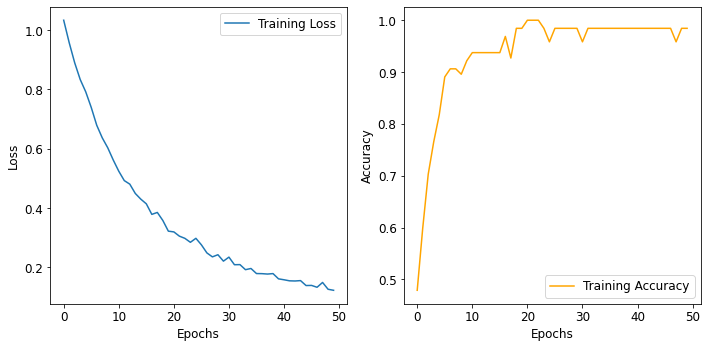

In [12]:
# Training

## Creating the model
num_neurons = 32
model, criterion, optimizer = create_and_initialize_classification_model(X_train_tensor, num_neurons)

## Getting the data loaders
batch_size = 8
train_loader = create_dataset_dataloader(X_train_tensor, y_train_tensor, batch_size, True)
cal_loader = create_dataset_dataloader(X_cal_tensor, y_cal_tensor, batch_size, True)
test_loader = create_dataset_dataloader(X_test_tensor, y_test_tensor, batch_size, True)

## Model Training
num_epochs = 50
train_model(model, criterion, optimizer, train_loader, num_epochs)

#### Conformal Uncertainity Quantification

##### Original

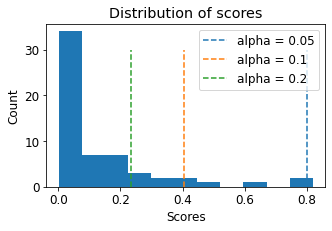

In [13]:
# Conformal Uncertainity Quantification

## Cal model output probabilities
y_cal_prob = model_prediction_classification(model, X_cal_tensor)
cal_scores = get_calibration_scores_orig(X_cal_tensor, y_cal_tensor, y_cal_prob)

## Quantiles
alphas = [0.05, 0.1, 0.2]
quantiles = [find_quantile(cal_scores, alpha) for alpha in alphas]

## Plotting
plot_scores(alphas, cal_scores, quantiles, 30)

In [14]:
# Prediction Set

prediction_sets, mean_width, pct_coverage, qhat = cuq_pred_set_orig(cal_scores, 0.1, model, X_test_tensor, y_test_tensor)

Example prediction sets: [[ True False False]
 [ True False False]
 [False False  True]
 [ True False False]
 [False  True False]]


Mean Width of Prediction Set: 0.9666666666666667


Percent Coverage: 0.9666666666666667


##### Adaptive

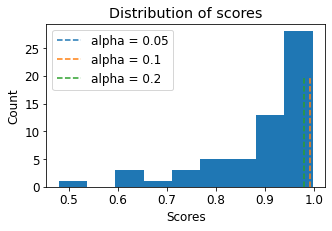

In [15]:
# Conformal Uncertainity Quantification

## Cal model output probabilities
y_cal_prob = model_prediction_classification(model, X_cal_tensor)
cal_scores = get_calibration_scores_adaptive(X_cal, y_cal, y_cal_prob)
X_cal_wine = X_cal
y_cal_wine = y_cal
y_cal_prob_wine = y_cal_prob
## Quantiles
alphas = [0.05, 0.1, 0.2]
quantiles = [find_quantile(cal_scores, alpha) for alpha in alphas]

## Plotting
plot_scores(alphas, cal_scores, quantiles, 20)

In [16]:
# Prediction Set

prediction_sets, mean_width, pct_coverage, qhat = cuq_pred_set_lar(model, cal_scores, X_test_tensor, y_test, 0.1)
print(f'Example prediction set: {prediction_sets[0]}')
print(f'Mean width: {mean_width}')
print(f'Percent/Emprical Coverage {pct_coverage}')
print(f'Associated q_hat: {qhat}')



Percent Coverage: 0.9833333333333333
Example prediction set: [ True  True False]
Mean width: 1.75
Percent/Emprical Coverage 0.9833333333333333
Associated q_hat: 0.9914429783821106
